# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Training language model (Many-to-Many) and generating sequences (One-to-Many)

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 
- 2022/06/15 (changed to tensorfow.keras, added translation of questions in EN)
- 2022/10/03 (added ReLU, np_epoch=20)

For any remark or suggestion, please feel free to contact me.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [1]:
%%capture
import os
import pretty_midi
from scipy.io import wavfile 
import IPython

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation

import matplotlib.pyplot as plt
import numpy as np
import glob

import copy

student = True

# Get the data

In [10]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [3]:
DIR = './'
import urllib.request
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['.\\cs1-1pre.mid', '.\\cs1-2all.mid', '.\\cs1-3cou.mid', '.\\cs1-4sar.mid', '.\\cs1-5men.mid', '.\\cs1-6gig.mid', '.\\cs2-1pre.mid', '.\\cs2-2all.mid', '.\\cs2-3cou.mid', '.\\cs2-4sar.mid', '.\\cs2-5men.mid', '.\\cs2-6gig.mid', '.\\cs3-1pre.mid', '.\\cs3-2all.mid', '.\\cs3-3cou.mid', '.\\cs3-4sar.mid', '.\\cs3-5bou.mid', '.\\cs3-6gig.mid', '.\\cs4-1pre.mid', '.\\cs4-2all.mid', '.\\cs4-3cou.mid', '.\\cs4-4sar.mid', '.\\cs4-5bou.mid', '.\\cs4-6gig.mid', '.\\cs5-1pre.mid', '.\\cs5-2all.mid', '.\\cs5-3cou.mid', '.\\cs5-4sar.mid', '.\\cs5-5gav.mid', '.\\cs5-6gig.mid', '.\\cs6-1pre.mid', '.\\cs6-2all.mid', '.\\cs6-3cou.mid', '.\\cs6-4sar.mid', '.\\cs6-5gav.mid', '.\\cs6-6gig.mid']


## Read and convert all MIDI files

In [11]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midiFile_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 43, start: 0.000000, end: 0.187500, duration: 0.187500
pitch: 50, start: 0.187500, end: 0.375000, duration: 0.187500
pitch: 59, start: 0.375000, end: 0.562500, duration: 0.187500
pitch: 57, start: 0.562500, end: 0.750000, duration: 0.187500
pitch: 59, start: 0.750000, end: 0.937500, duration: 0.187500
pitch: 50, start: 0.937500, end: 1.125000, duration: 0.187500
pitch: 59, start: 1.125000, end: 1.312500, duration: 0.187500
pitch: 50, start: 1.312500, end: 1.500000, duration: 0.187500
pitch: 43, start: 1.500000, end: 1.687500, duration: 0.187500
pitch: 50, start: 1.687500, end: 1.875000, duration: 0.187500
pitch: 59, start: 1.875000, end: 2.062500, duration: 0.187500
pitch: 57, start: 2.062500, end: 2.250000, duration: 0.187500
pitch: 59, start: 2.250000, end: 2.437500, duration: 0.187500
pitch: 50, start: 2.437500, end: 2.625000, duration: 0.187500
pitch: 59, start: 2.625000, end: 2.812500, duration: 0.187500
pitch: 50, start: 2.812500, end: 3.000000, duration: 0.187500
pitch: 4

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [12]:
# --- We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
        T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
        X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(593, 79)
(914, 79)
(812, 79)


## Display the set of notes over time for a specific track 

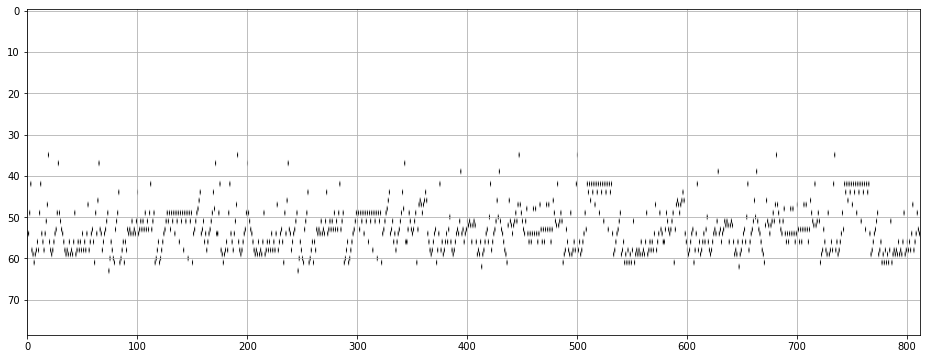

In [13]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_02.png">


In [14]:
X_train_list = []
y_train_list = []

if student:
    # --- START CODE HERE (01)
    for sequence in X_list:
        for i in range(sequence.shape[0]-sequence_length):
            X_train_list.append(sequence[i:i+sequence_length])
            y_train_list.append(sequence[i+sequence_length])
    
    # --- END CODE HERE

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23781, 20, 79)
y_train.shape: (23781, 79)


# Training the language model

The language model will be learned by training an RNN with input `X_train` and output `Y_train`:  for each of the examples of sequences, we give to the network a sequence of notes of `sequence_length` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- (1a) a layer of `LSTM` with $n_a$=256
- (1b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (2a) a layer of `LSTM` with $n_a$=256
- (2b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (3) a layer of `LSTM` with $n_a$=256
- (4a) a layer of `Dense` with 256 units and a `ReLU` activation
- (4b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (5) a layer of `Dense` with a `softmax` activation which predict the probability of each of the $n_x$ notes as output

## Returning the hidden states at each time of an LSTM cell

Note that when we stack one LSTM layer on top of a second LSTM layer (deep-RNN), we need to tell the first LSTM to output its hidden states at each time $t$. This is done by the option `return_sequences=True` that has to be given as parameter to the LSTM on top of the other one.
This is the case for (1a) and (2a).

However, since we are only interrested in the last hidden state of the third LSTM (since we are only interrest in its prediction at time $T_x$), we give the option `return_sequences=False` (which is the default behaviour) for the third LSTM.
This is the case for (3).

In [15]:
# --- Create the model
K.clear_session()

if student:
    # --- START CODE HERE (02)
    model = Sequential(name='LSTM_language_model')
    model.add(Input(shape=(sequence_length, n_x)))
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(rate=0.3))
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(rate=0.3))
    model.add(LSTM(units=256, return_sequences=False))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=n_x, activation='softmax'))
    # --- END CODE HERE

print(model.summary())

Model: "LSTM_language_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           344064    
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)       

In [16]:
# --- Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
23781/23781 [==============================] - 103s 4ms/sample - loss: 2.9605 - acc: 0.1150
Epoch 2/20
23781/23781 [==============================] - 103s 4ms/sample - loss: 2.6076 - acc: 0.1607
Epoch 3/20
23781/23781 [==============================] - 101s 4ms/sample - loss: 2.5150 - acc: 0.1902
Epoch 4/20
23781/23781 [==============================] - 102s 4ms/sample - loss: 2.4539 - acc: 0.2235
Epoch 5/20
23781/23781 [==============================] - 101s 4ms/sample - loss: 2.3850 - acc: 0.2518
Epoch 6/20
23781/23781 [==============================] - 103s 4ms/sample - loss: 2.3081 - acc: 0.2825
Epoch 7/20
23781/23781 [==============================] - 105s 4ms/sample - loss: 2.2113 - acc: 0.3139
Epoch 8/20
23781/23781 [==============================] - 102s 4ms/sample - loss: 2.1202 - acc: 0.3465
Epoch 9/20
23781/23781 [==============================] - 104s 4ms/sample - loss: 2.0070 - acc: 0.3765
Epoch 10/20
23781/23781 [==============================] - 103s 4ms/sampl

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 23.781 sequences used for training.

- The ```pattern``` variable is the ```list``` of init notes to which we progressively append the new generated notes by the model.
- The ```prediction``` variable is a ```list``` which stores the softmax probability vector (a numpy array) corresponding to each generation time.


In [36]:
# --- Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

16590
(20, 79)
(1, 20, 79)


In [43]:
# --- note_l: is the list of notes (integer number) over time
note_l = []
# --- prediction_l: is the list of output-vectors (float numbers \in [0,1]) of the network over time
prediction_l = []
# --- Generate T_y_generated notes
for note_index in range(T_y_generated):
    if student:
        # --- START CODE HERE (03)
        prediction = model.predict(np.expand_dims(pattern, 0))
        prediction_l.append(prediction)
        idx = np.argmax(prediction)
        note_l.append(idx)
        # one hot encoding
        X_ohe = np.zeros((n_x))
        X_ohe[idx] = 1
        pattern = np.append(pattern[1:], np.expand_dims(X_ohe, 0), axis=0)
        # --- END CODE HERE    


### Display the generated sequence

[54, 52, 50, 49, 47, 46, 47, 50, 49, 47, 46, 47, 50, 52, 54, 55, 52, 49, 52, 50, 49, 47, 38, 42, 35, 42, 35, 47, 35, 47, 50, 49, 50, 52, 54, 55, 52, 49, 50, 50, 49, 47, 47, 49, 50, 52, 54, 55, 57, 59, 57, 55, 57, 59, 55, 54, 52, 54, 50, 49, 47, 45, 47, 49, 50, 52, 50, 52, 54, 55, 52, 54, 52, 50, 49, 50, 52, 49, 45, 47, 49, 50, 52, 54, 55, 57, 59, 61, 62, 54, 50, 50, 45, 47, 49, 45, 38, 50, 52, 54, 50, 52, 54, 55, 52, 38, 52, 50, 49, 52, 50, 49, 52, 58, 61, 54, 52, 50, 49, 50, 52, 54, 55, 57, 59, 61, 62, 61, 62, 61, 59, 57, 55, 54, 52, 50, 52, 50, 49, 47, 45, 52, 45, 47, 49, 50, 52, 54, 47, 55, 49, 55, 50, 52, 54, 55, 57, 59, 54, 60, 52, 60, 52, 55, 54, 55, 57, 59, 57, 59, 55, 57, 59, 57, 55, 57, 54, 43, 55, 52, 54, 55, 54, 52, 54, 55, 57, 59, 57, 55, 57, 55, 54, 55, 54, 52, 54, 52, 50, 49]


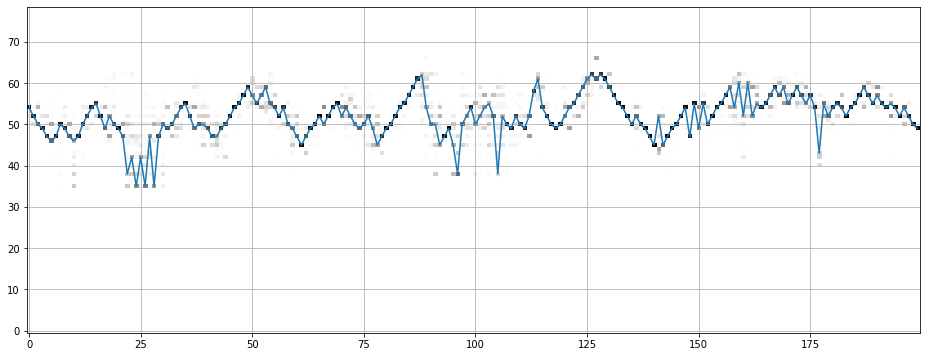

In [44]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto', origin='lower')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [45]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
new_midi_data.write('output.mid')

In [46]:
%matplotlib inline

audio_data = new_midi_data.synthesize(fs=44100)
IPython.display.Audio(audio_data, rate=44100)

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Data conversion for the training of language model (01)
- 2) Training the language model (02)
- 3) Generating a new sequence from sampling the language model (03)

You will also rate the answer to the four questions below.

## Question 1)

What happens if we replace the LSTM cell by a RNNsimple cell?

**Answer below** (1 points)

Answer: Gradient Vanishing

## Question 2) 

What happens if we shorten the length of the sequences used for training? How can this effect be avoided?

**Answer below** (1 points)

Answer: If we use shorter sequences to predict, the training accuracy will decrease, which is normal because we use less information. For example, when `sequence_length` equals to 10 (other hyper-parameters remaining the same), the training accuracy arrive at 73.6%, compared with 76% when `sequence_length` equals to 20. But ther former training process is faster than the latter.

But, if we consider one extreme case: `sequence_length` equals to 1, the prediction coule not be well finished. There would no convergence and training accuracy remains at a low level.

Solution: Make the length of sequence stay in a reasonable scale. 



## Question 3) 

How could we make the system polyphonic (several notes played simultaneously by the same instrument)? for training? for generation?

**Answer below** (2 points)

Answer: What we did is, at each timestep, encoding one note by one-hot encoding. To make system polyphonic, we can encode several notes at one timestep, and concatenate their one-hot encoding (i.e several 1 in an one-hot vector).

For generation, we can pick several most probably notes in output as the notes in next timestep. Or, more randomly, pick several notes according to their probabilities stored in output.

## Question 4) 

We used a simplified procedure to train the musical language model, transforming the learning into a Many-To-one problem. Explain ? How does one usually train a language model with an RNN? What would be the advantage?

**Answer below** (2 points)

Answer: Here, we use a sequence of length 20 to predict the probability of being the next note for all available notes. It is convenient for novel music generation. The shortcoming is, we do not really get the probability of a given note sequence.

Usually, we would use an embedding layer before the LSTM/GRU. Advantage: taking into account the inner relationship between notes.
More importantly, a language model is often trained by a Many-to-Many model. At each timestep, the neurone gives the probability of each note (by softmax function), conditionnally on previous notes. Then by chain rule, we can obtain the probability of whole sequence. 
